In [1]:
import sys
sys.path.append("../../")

In [2]:
from utils.read_har import *
from datetime import datetime
from urllib.parse import urlparse, urlunparse
import pandas as pd
from hdfs import InsecureClient
from ta import add_all_ta_features
from ta.utils import dropna
import ta
from pyspark.sql import SparkSession
from pyspark import  SparkContext
import os
from sklearn.preprocessing import MinMaxScaler
import torch
import numpy as np
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torch.nn as nn
import matplotlib.pyplot as plt
import ta.momentum
from pathlib import Path

In [3]:
selenium_folder_path = str(get_selenium_path())

In [4]:
selenium_folder_path

'D:\\code\\selenium'

In [5]:
os.environ["JAVA_HOME"] = r'C:\Program Files\Java\jre-1.8'
os.environ["PYSPARK_PYTHON"] = "python" 

In [6]:
PARENT_FOLDER = "ssi"
REQUEST_FOLDER_PATH, RESPONSE_FOLDER_PATH = construct_folder(PARENT_FOLDER)

In [7]:
# Access the entries in the HAR file
file_name = "stock_price"
entries = read_data_network(os.path.abspath(os.path.join(selenium_folder_path, f"network_har/{PARENT_FOLDER}/{file_name}.har")))

list_text = [
    "https://iboard-api.ssi.com.vn/statistics/charts/history",
]
entries_find = find_list_request_have_text(
    list_text, entries)
write_dict_to_json_file(
    entries_find, f"{REQUEST_FOLDER_PATH}/entries_find_{file_name}.json")

In [8]:
len(entries_find)

13

In [9]:
index = 0
entry_have_data = entries_find[index]
request_of_entry = entry_have_data["request"]

index = f"{file_name}_{index}"
inspect_entry(entry_have_data, index, "file", REQUEST_FOLDER_PATH, RESPONSE_FOLDER_PATH)
# inspect_json_data(entry_have_data["response"]["content"]["text"], f"{index}_1", "file", RESPONSE_FOLDER_PATH)

In [10]:
headers = construct_name_value(request_of_entry["headers"])

headers_keys = list(headers.keys())[:]
for key in headers_keys:
    if key[0] == ":":
        del headers[key]

cockies = construct_name_value(request_of_entry["cookies"])

In [11]:
headers

{'accept': 'application/json, text/plain, */*',
 'accept-encoding': 'gzip, deflate, br, zstd',
 'accept-language': 'en-US,en;q=0.9',
 'origin': 'https://iboard.ssi.com.vn',
 'priority': 'u=1, i',
 'referer': 'https://iboard.ssi.com.vn/',
 'sec-ch-ua': '"Not/A)Brand";v="8", "Chromium";v="126", "Microsoft Edge";v="126"',
 'sec-ch-ua-mobile': '?0',
 'sec-ch-ua-platform': '"Windows"',
 'sec-fetch-dest': 'empty',
 'sec-fetch-mode': 'cors',
 'sec-fetch-site': 'same-site',
 'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/126.0.0.0 Safari/537.36 Edg/126.0.0.0'}

In [12]:
cockies

{}

In [13]:
query_string = construct_name_value(request_of_entry["queryString"])

In [14]:
query_string

{'resolution': '1D', 'symbol': 'FPT', 'from': '1496275200', 'to': '1719187200'}

In [15]:
# ONE_MINUTE = "1"
# FIVE_MINUTES = "5"
# FIFTEEN_MINUTES = "15"
# THIRTY_MINUTES = "30"

# ONE_HOUR = "1H"

# ONE_DAY = "1D"
# ONE_WEEK = "1W"
# ONE_MONTH = "1M"

In [16]:
query_string["resolution"] = "1D"
query_string["from"] = str(datetime(2000, 1, 1).timestamp())
query_string["to"] = str(datetime.now().timestamp())

In [17]:
datetime.fromtimestamp(1165968000)

datetime.datetime(2006, 12, 13, 7, 0)

In [18]:
query_string

{'resolution': '1D',
 'symbol': 'FPT',
 'from': '946659600.0',
 'to': '1731411370.073062'}

In [19]:
parsed_url = urlparse(request_of_entry["url"])
url_without_params = urlunparse((parsed_url.scheme, parsed_url.netloc, parsed_url.path, '', '', ''))


In [20]:
url_without_params

'https://iboard-api.ssi.com.vn/statistics/charts/history'

In [21]:
headers

{'accept': 'application/json, text/plain, */*',
 'accept-encoding': 'gzip, deflate, br, zstd',
 'accept-language': 'en-US,en;q=0.9',
 'origin': 'https://iboard.ssi.com.vn',
 'priority': 'u=1, i',
 'referer': 'https://iboard.ssi.com.vn/',
 'sec-ch-ua': '"Not/A)Brand";v="8", "Chromium";v="126", "Microsoft Edge";v="126"',
 'sec-ch-ua-mobile': '?0',
 'sec-ch-ua-platform': '"Windows"',
 'sec-fetch-dest': 'empty',
 'sec-fetch-mode': 'cors',
 'sec-fetch-site': 'same-site',
 'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/126.0.0.0 Safari/537.36 Edg/126.0.0.0'}

In [22]:
query_string

{'resolution': '1D',
 'symbol': 'FPT',
 'from': '946659600.0',
 'to': '1731411370.073062'}

In [21]:
response = requests.get(
    url=url_without_params,
    headers=headers,
    params=query_string
)

In [22]:
response.status_code

200

In [23]:
df_fpt = pd.DataFrame(response.json()["data"])

In [24]:
df_fpt

,t,c,o,h,l,v,s
0,1165968000,11.52,11.52,11.52,11.52,83530,ok
1,1166054400,12.09,12.09,12.09,12.09,280710,ok
2,1166140800,12.70,12.70,12.70,12.70,265300,ok
3,1166400000,13.33,13.33,13.33,13.33,215790,ok
4,1166486400,13.99,13.99,13.99,13.99,137520,ok
...,...,...,...,...,...,...,...
4380,1723161600,126.90,122.40,126.90,122.00,5496400,ok
4381,1723420800,130.00,126.90,130.20,126.20,6183500,ok
4382,1723507200,129.70,129.70,130.20,128.00,4097900,ok
4383,1723593600,129.50,130.70,131.50,129.50,2862200,ok


In [25]:
write_dict_to_json_file(response.json(), "./data.json")

In [26]:
# if response.status_code == 200:
#     data = response.text  # Lấy nội dung của phản hồi dưới dạng text
    
#     # Kết nối tới HDFS
#     hdfs_url = "http://localhost:50070"  # Địa chỉ NameNode của HDFS
#     hdfs_client = InsecureClient(hdfs_url, user='hdfs')  # Tên người dùng trong HDFS
    
#     # Đường dẫn tệp trên HDFS để lưu dữ liệu
#     hdfs_path = "/user/hdfs/api_data.json"
    
#     # Ghi dữ liệu vào tệp trên HDFS
#     with hdfs_client.write(hdfs_path, encoding='utf-8') as writer:
#         writer.write(data)
    
#     print(f"Dữ liệu đã được lưu vào HDFS tại {hdfs_path}")
# else:
#     print(f"Yêu cầu không thành công, mã trạng thái: {response.status_code}")

In [27]:
# if response.status_code == 200:
#     # Giả sử dữ liệu trả về là JSON và bạn muốn chuyển đổi nó thành DataFrame
#     data = response.json()  # Lấy nội dung của phản hồi dưới dạng JSON
#     df = pd.DataFrame(data)  # Chuyển đổi JSON thành DataFrame
    
#     # Lưu DataFrame dưới dạng Parquet vào một tệp cục bộ tạm thời
#     local_parquet_path = "data.parquet"
#     df.to_parquet(local_parquet_path, engine='pyarrow', index=False)
    
#     # Kết nối tới HDFS
#     hdfs_url = "http://localhost:50070"  # Địa chỉ NameNode của HDFS
#     hdfs_client = InsecureClient(hdfs_url, user='hdfs')  # Tên người dùng trong HDFS
    
#     # Đường dẫn tệp trên HDFS để lưu dữ liệu
#     hdfs_path = "/user/hdfs/api_data.parquet"
    
#     # Ghi tệp Parquet từ máy cục bộ vào HDFS
#     hdfs_client.upload(hdfs_path, local_parquet_path)
    
#     print(f"Dữ liệu đã được lưu vào HDFS dưới dạng Parquet tại {hdfs_path}")
# else:
#     print(f"Yêu cầu không thành công, mã trạng thái: {response.status_code}")

In [28]:
df_fpt

,t,c,o,h,l,v,s
0,1165968000,11.52,11.52,11.52,11.52,83530,ok
1,1166054400,12.09,12.09,12.09,12.09,280710,ok
2,1166140800,12.70,12.70,12.70,12.70,265300,ok
3,1166400000,13.33,13.33,13.33,13.33,215790,ok
4,1166486400,13.99,13.99,13.99,13.99,137520,ok
...,...,...,...,...,...,...,...
4380,1723161600,126.90,122.40,126.90,122.00,5496400,ok
4381,1723420800,130.00,126.90,130.20,126.20,6183500,ok
4382,1723507200,129.70,129.70,130.20,128.00,4097900,ok
4383,1723593600,129.50,130.70,131.50,129.50,2862200,ok


In [29]:
# Thêm chỉ số MACD vào DataFrame
df_fpt["macd"] = ta.trend.macd(df_fpt["c"])
df_fpt["macd_signal"] = ta.trend.macd_signal(df_fpt["c"])
df_fpt["histogram"] = ta.trend.macd_diff(df_fpt["c"])

In [30]:



df_fpt["rsi"] = ta.momentum.rsi(df_fpt["c"])

In [31]:
df_fpt

,t,c,o,h,l,v,s,macd,macd_signal,histogram,rsi
0,1165968000,11.52,11.52,11.52,11.52,83530,ok,NaN,NaN,NaN,NaN
1,1166054400,12.09,12.09,12.09,12.09,280710,ok,NaN,NaN,NaN,NaN
2,1166140800,12.70,12.70,12.70,12.70,265300,ok,NaN,NaN,NaN,NaN
3,1166400000,13.33,13.33,13.33,13.33,215790,ok,NaN,NaN,NaN,NaN
4,1166486400,13.99,13.99,13.99,13.99,137520,ok,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4380,1723161600,126.90,122.40,126.90,122.00,5496400,ok,-1.722477,-1.336433,-0.386043,51.089572
4381,1723420800,130.00,126.90,130.20,126.20,6183500,ok,-1.158721,-1.300891,0.142170,55.972507
4382,1723507200,129.70,129.70,130.20,128.00,4097900,ok,-0.727759,-1.186265,0.458505,55.396135
4383,1723593600,129.50,130.70,131.50,129.50,2862200,ok,-0.397772,-1.028566,0.630794,54.989596


In [32]:
spark: SparkSession = SparkSession.builder.master("local").getOrCreate()

In [33]:
df_person = spark.createDataFrame(df_fpt)
df_person.createOrReplaceTempView("fpt_stock")

In [34]:
D = spark.sql("""
    WITH fpt_stock_plus AS (
        SELECT
            to_date(CAST(t AS TIMESTAMP)) AS date_trade,
            c AS close_price,
            macd, 
            macd_signal,
            histogram,
            LAG(histogram) OVER(ORDER BY t) AS previous_histogram,
            LEAD(histogram) OVER(ORDER BY t) AS next_histogram,
            rsi,
            LAG(rsi) OVER(ORDER BY t) AS previous_rsi,
            LEAD(rsi) OVER(ORDER BY t) AS next_rsi
        FROM fpt_stock
    )
          
    SELECT
        *
    FROM fpt_stock_plus
""")
D.show(50)

+----------+-----------+------------------+------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+
|date_trade|close_price|              macd|       macd_signal|           histogram|  previous_histogram|      next_histogram|               rsi|      previous_rsi|          next_rsi|
+----------+-----------+------------------+------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+
|2006-12-13|      11.52|               NaN|               NaN|                 NaN|                NULL|                 NaN|               NaN|              NULL|               NaN|
|2006-12-14|      12.09|               NaN|               NaN|                 NaN|                 NaN|                 NaN|               NaN|               NaN|               NaN|
|2006-12-15|       12.7|               NaN|               NaN|                 NaN|  

In [35]:
D1 = spark.sql("""
    WITH fpt_stock_plus AS (
        SELECT
            to_date(CAST(t AS TIMESTAMP)) AS date_trade,
            c AS close_price,
            macd, 
            macd_signal,
            histogram,
            LAG(histogram) OVER(ORDER BY t) AS previous_histogram,
            LEAD(histogram) OVER(ORDER BY t) AS next_histogram,
            rsi,
            LAG(rsi) OVER(ORDER BY t) AS previous_rsi,
            LEAD(rsi) OVER(ORDER BY t) AS next_rsi
        FROM fpt_stock
    )
    
    SELECT
        *,
        date_trade AS start_trend_date
    FROM (
        SELECT
            *,
            LEAD(date_trade) OVER(ORDER BY date_trade) AS end_trend_date
        FROM (   
            (SELECT
                *,
                "START" as type
            FROM fpt_stock_plus 
                WHERE histogram < 0
                AND next_histogram > 0)
            UNION ALL
            (SELECT
                *,
                "END" as type
            FROM fpt_stock_plus 
                WHERE histogram < 0
                AND previous_histogram > 0)
        )        
    )
    WHERE type = "START"
    ORDER BY date_trade
""")
D1.show(20)

+----------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+-----+--------------+----------------+
|date_trade|close_price|                macd|         macd_signal|           histogram|  previous_histogram|      next_histogram|               rsi|      previous_rsi|          next_rsi| type|end_trend_date|start_trend_date|
+----------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+-----+--------------+----------------+
|2007-04-10|      15.01| -0.5653527464718167| -0.5442612383980054|-0.02109150807381...|-0.05940704714403755|0.016649626703627685| 42.77451615423417| 40.87680123612303| 44.13756040388646|START|    2007-04-20|      2007-04-10|
|2007-05-07|      14.03| -0.7165373787914611| -0.7036175677226337|-0.01291981106882...|-0.1159927897

In [36]:
df_D = D.toPandas()

In [37]:
df_D["date_trade"] = pd.to_datetime(df_D["date_trade"])

In [38]:
df_D.dtypes

date_trade            datetime64[ns]
close_price                  float64
macd                         float64
macd_signal                  float64
histogram                    float64
previous_histogram           float64
next_histogram               float64
rsi                          float64
previous_rsi                 float64
next_rsi                     float64
dtype: object

In [39]:
df_D1 = D1.toPandas()

In [40]:
df_D1 = df_D1[df_D1["end_trend_date"].notna()]

In [41]:
df_D1

,date_trade,close_price,macd,macd_signal,histogram,previous_histogram,next_histogram,rsi,previous_rsi,next_rsi,type,end_trend_date,start_trend_date
0,2007-04-10,15.01,-0.565353,-0.544261,-0.021092,-0.059407,0.016650,42.774516,40.876801,44.137560,START,2007-04-20,2007-04-10
1,2007-05-07,14.03,-0.716537,-0.703618,-0.012920,-0.115993,0.083027,46.865237,40.113670,50.336882,START,2007-05-29,2007-05-07
2,2007-06-25,13.36,-0.516202,-0.446256,-0.069946,-0.120061,0.010681,41.622494,31.230369,50.249724,START,2007-07-16,2007-06-25
3,2007-08-08,10.35,-0.892671,-0.819247,-0.073424,-0.147827,0.015161,34.237093,24.789920,42.219521,START,2007-10-17,2007-08-08
4,2007-12-18,9.77,-0.337989,-0.311833,-0.026156,-0.040200,0.004091,33.289963,27.992954,42.715347,START,2008-01-04,2007-12-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,2024-01-31,82.65,0.113798,0.190502,-0.076704,-0.088170,0.163787,51.372390,50.598909,71.024097,START,2024-03-11,2024-01-31
165,2024-03-12,96.64,2.582153,2.607981,-0.025828,-0.046665,0.245608,69.834398,65.607658,77.739026,START,2024-03-19,2024-03-12
166,2024-04-24,103.72,0.404940,0.452810,-0.047870,-0.596651,0.465508,64.562312,49.312871,68.606700,START,2024-05-24,2024-04-24
167,2024-06-07,122.63,3.530503,3.544493,-0.013991,-0.140101,0.143876,69.613883,66.341610,72.058788,START,2024-06-25,2024-06-07


In [118]:
start_end_DF = pd.DataFrame()

In [119]:
start_end_DF["start_trend_date"] = pd.to_datetime(df_D1["start_trend_date"])
start_end_DF["end_trend_date"] = pd.to_datetime(df_D1["end_trend_date"])

In [120]:
df_macd = df_D[["date_trade", "close_price",
                "macd",	"macd_signal", "histogram"]]

In [121]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [122]:
def construct_scaler_macd_data(df, scaler):
    df_scaled = df[["date_trade"]]
    df_scaled[["close_price", "macd", "macd_signal", "histogram"]] = scaler.fit_transform(
        df[["close_price", "macd", "macd_signal", "histogram"]])
    return df_scaled

In [123]:
df_macd_value = construct_scaler_macd_data(df_macd, scaler)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_17848\3473851728.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scaled[["close_price", "macd", "macd_signal", "histogram"]] = scaler.fit_transform(
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_17848\3473851728.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scaled[["close_price", "macd", "macd_signal", "histogram"]] = scaler.fit_transform(
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_17848\3473851728.py:3: SettingWithCopyWarning: 
A value is trying to

In [124]:
def generate_sequence(start_end_DF, df_macd_value, output_size=1):
    xs, ys, seq_lengths = [], [], []
    start_end = []
    for index, row in start_end_DF.iterrows():
        start_date = row["start_trend_date"]
        end_date = row["end_trend_date"]

        data = df_macd_value[(df_macd_value["date_trade"] >= start_date) & (
            df_macd_value["date_trade"] <= end_date)]
        

        last_index_of_data = int(df_macd_value[df_macd_value["date_trade"] == end_date].index.values[0])
        
        output = df_macd_value.iloc[last_index_of_data + 1:last_index_of_data + output_size + 1]
        
        if (len(output) != output_size):
            continue
        
        xs.append(data[["close_price", "macd", "macd_signal", "histogram"]].values)
        ys.append(output["close_price"])
        seq_lengths.append(len(data))
        
        start_end.append((start_date, end_date))

    return xs, np.array(ys), np.array(seq_lengths), start_end


In [125]:
X, y, seq_lengths, _ = generate_sequence(start_end_DF, df_macd_value, 10)

In [126]:
def create_tensor_data(X, y, seq_lengths):
    X_train = [torch.tensor(x, dtype=torch.float32) for x in X]
    y_train = torch.tensor(y, dtype=torch.float32)
    seq_lengths_train = torch.tensor(seq_lengths)
    
    X_train_padded = pad_sequence(X_train, batch_first=True)
    
    return X_train, X_train_padded, y_train, seq_lengths_train

In [127]:
X_train, X_train_padded, y_train, seq_lengths_train = create_tensor_data(X, y, seq_lengths)

In [128]:
class StockD1LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(StockD1LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, lengths):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        packed_input = torch.nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input, (h0, c0))
        output, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        out = self.fc(output[torch.arange(x.size(0)), lengths - 1])
        return out


In [129]:
input_size = 4
hidden_size = 50
num_layers = 2
output_size = 10

model = StockD1LSTM(input_size, hidden_size, num_layers, output_size)

In [134]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 300
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_padded, seq_lengths_train)
    loss = criterion(outputs, y_train)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.20f}')


Epoch [10/300], Loss: 0.00115229247603565454
Epoch [20/300], Loss: 0.00013686741294804960
Epoch [30/300], Loss: 0.00008242559124482796
Epoch [40/300], Loss: 0.00009249988943338394
Epoch [50/300], Loss: 0.00006027486233506352
Epoch [60/300], Loss: 0.00004762703974847682
Epoch [70/300], Loss: 0.00004385213469504379
Epoch [80/300], Loss: 0.00004241876376909204
Epoch [90/300], Loss: 0.00004161303149885498
Epoch [100/300], Loss: 0.00004123225880903192
Epoch [110/300], Loss: 0.00004112366514164023
Epoch [120/300], Loss: 0.00004101852027815767
Epoch [130/300], Loss: 0.00004090393485967070
Epoch [140/300], Loss: 0.00004080513826920651
Epoch [150/300], Loss: 0.00004070215072715655
Epoch [160/300], Loss: 0.00004060019273310900
Epoch [170/300], Loss: 0.00004049685594509356
Epoch [180/300], Loss: 0.00004039234772790223
Epoch [190/300], Loss: 0.00004028678813483566
Epoch [200/300], Loss: 0.00004017987157567404
Epoch [210/300], Loss: 0.00004007169627584517
Epoch [220/300], Loss: 0.000039962222217582

In [135]:
model.eval()
with torch.no_grad():
    train_predict = model(X_train_padded, torch.tensor(seq_lengths))
    test_loss = criterion(train_predict, y_train)
    print(f'Test Loss: {test_loss.item():.20f}')

# Chuyển đổi lại giá trị về phạm vi ban đầu


Test Loss: 0.00003902932439814322


In [132]:
train_predict.shape

torch.Size([169, 10])

In [178]:
data = df_D[(df_D["date_trade"] >= "2024-04-23") & (df_D["date_trade"] <= "2024-06-25")].reset_index()

In [199]:
data = construct_scaler_macd_data(df_macd, scaler)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_17848\3473851728.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scaled[["close_price", "macd", "macd_signal", "histogram"]] = scaler.fit_transform(
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_17848\3473851728.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scaled[["close_price", "macd", "macd_signal", "histogram"]] = scaler.fit_transform(
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_17848\3473851728.py:3: SettingWithCopyWarning: 
A value is trying to

In [200]:
data

,date_trade,close_price,macd,macd_signal,histogram
0,2006-12-13,0.068374,NaN,NaN,NaN
1,2006-12-14,0.072520,NaN,NaN,NaN
2,2006-12-15,0.076957,NaN,NaN,NaN
3,2006-12-18,0.081539,NaN,NaN,NaN
4,2006-12-19,0.086340,NaN,NaN,NaN
...,...,...,...,...,...
4380,2024-08-09,0.907623,0.061737,0.079941,0.419189
4381,2024-08-12,0.930172,0.135398,0.085133,0.587483
4382,2024-08-13,0.927990,0.191708,0.101875,0.688271
4383,2024-08-14,0.926535,0.234825,0.124909,0.743164


In [201]:
start_end_DF = pd.DataFrame({
    "start_trend_date": ["2024-04-24"],
    "end_trend_date": ["2024-05-10"],
})
X_test, y_test, seq_lengths_test, _ = generate_sequence(
    start_end_DF=start_end_DF,
    df_macd_value=data,
    output_size=10
)

In [202]:
X_test, X_test_padded, y_test, seq_lengths_test = create_tensor_data(X_test, y_test, seq_lengths_test)

In [203]:
model.eval()
with torch.no_grad():
    test_predict = model(X_test_padded, torch.tensor(seq_lengths_test))
    

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_17848\3608567555.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_predict = model(X_test_padded, torch.tensor(seq_lengths_test))


In [204]:
y_test

tensor([[0.7993, 0.8043, 0.8270, 0.8351, 0.8294, 0.8200, 0.8389, 0.8515, 0.8483,
         0.8131]])

In [205]:
test_predict

tensor([[0.8295, 0.8538, 0.8480, 0.8520, 0.8439, 0.8487, 0.8557, 0.8547, 0.8662,
         0.8587]])

In [212]:
y_test_array = y_test.numpy()[0]
test_predict_array = test_predict.numpy()[0]

In [213]:
x = np.array(["13", "14", "15", "16", "17", "20", "21", "22", "23", "24"])

In [214]:
x

array(['13', '14', '15', '16', '17', '20', '21', '22', '23', '24'],
      dtype='<U2')

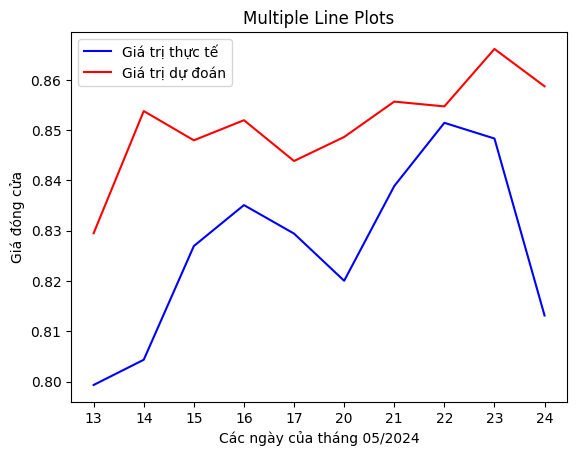

In [216]:
plt.plot(x, y_test_array, label="Giá trị thực tế", color="blue")
plt.plot(x, test_predict_array, label="Giá trị dự đoán", color="red")

# Thêm tiêu đề, nhãn trục và chú thích
plt.title("Multiple Line Plots")
plt.xlabel("Các ngày của tháng 05/2024")
plt.ylabel("Giá đóng cửa")
plt.legend()

# Hiển thị biểu đồ
plt.show()